Load external libs

In [1]:
from pathlib import Path

import numpy as np
from numpy.lib.stride_tricks import as_strided
from skimage.io import imread, imshow
import matplotlib.pyplot as plt
from skimage.util import view_as_windows, pad
import cv2

from applications import UNetSS

%matplotlib inline

Using TensorFlow backend.


load test files for evaluation

In [2]:
test_image_paths = Path('/root/input/AerialImageDataset/test/images/').glob('./*.tif')

define image util func

In [3]:
def show_img(img: np.ndarray):
    plt.figure(figsize=(6, 6))
    imshow(img)

load test image

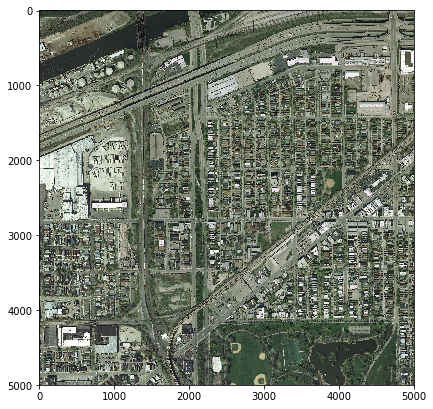

In [4]:
test_image_path = next(test_image_paths)
test_image = imread(test_image_path.as_posix())
show_img(test_image)

load trained model

In [5]:
weight_path = Path('/root/output/unet_ss_epoch100/weights_100.h5')
model = UNetSS(weight_path.as_posix(), batch_normalize=True)

Instructions for updating:
Colocations handled automatically by placer.


load constants from patch size to extract half center region of patch image for prediction value

In [6]:
patch_size = 512
half_patch_size = patch_size // 2
image_size = test_image.shape[0]
patch_count = image_size // half_patch_size + 1
pad_size = (patch_count + 1) * half_patch_size - image_size
half_pad_size = pad_size // 2

pad test image in symmetric mode

In [7]:
padded_test_image = pad(test_image, ((half_pad_size,half_pad_size), (half_pad_size,half_pad_size), (0,0)), 'symmetric')
padded_test_image.shape

(5376, 5376, 3)

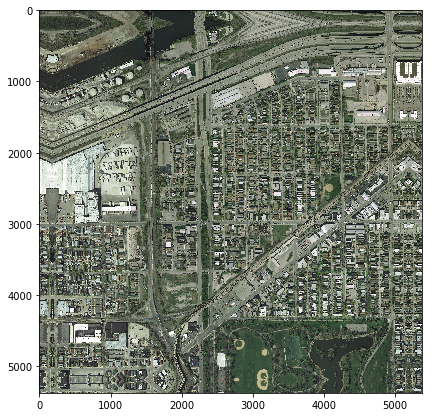

In [8]:
show_img(padded_test_image)

generate patches with stride of half patch size

In [9]:
patches = view_as_windows(padded_test_image, (patch_size, patch_size, 3), step=half_patch_size)
patches.shape

(20, 20, 1, 512, 512, 3)

concat patch axis

In [10]:
re_patches = patches.reshape((patch_count * patch_count, patch_size, patch_size, 3))
re_patches.shape

(400, 512, 512, 3)

predict for concatted patches

In [11]:
predict_patch_list = model.predict(re_patches / 255., batch_size=1)
predict_patch_list[0].shape

(400, 512, 512, 2)

In [12]:
stacked_predict_patch = np.stack(predict_patch_list)
stacked_predict_patch.shape

(3, 400, 512, 512, 2)

reshape patch axis

In [13]:
re_predicted_patch = stacked_predict_patch.reshape((3, patch_count, patch_count, patch_size, patch_size, 2))
re_predicted_patch.shape

(3, 20, 20, 512, 512, 2)

use center of prediction as an output

In [14]:
center_slice = slice(half_patch_size // 2, half_patch_size // 2 + half_patch_size)
center_predicted_patches = \
re_predicted_patch[:,:,:,center_slice,center_slice,:]
center_predicted_patches.shape

(3, 20, 20, 256, 256, 2)

concat prediction patches to make whole prediction output 

In [15]:
predict_one_hot = np.concatenate(
    np.concatenate(
        center_predicted_patches.transpose(1, 2, 3, 4, 0, 5), 
        axis=1
    ).transpose(0, 2, 1, 3, 4)
).transpose(2, 1, 0, 3)
predict_one_hot.shape

(3, 5120, 5120, 2)

extract prediction output

In [16]:
original_slice = slice(half_pad_size // 2, half_pad_size // 2 + 5000)
predict_bin_image = np.where(predict_one_hot[:,original_slice,original_slice, 1] > 0.4, 1, 0).astype(np.uint8)

show small output

/usr/local/lib/python3.5/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:75: UserWarning: Low image data range; displaying image with stretched contrast.
  warn("Low image data range; displaying image with "


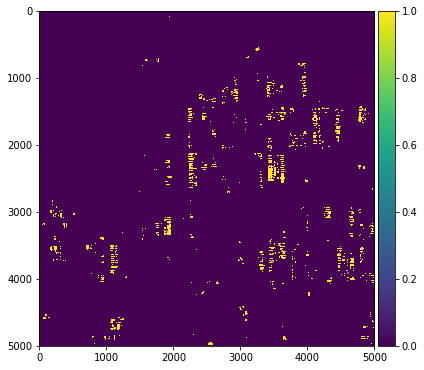

In [17]:
show_img(predict_bin_image[0])

show medium output

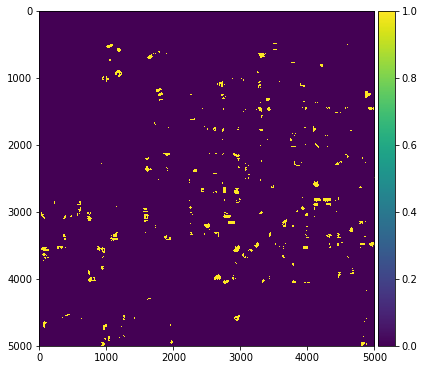

In [18]:
show_img(predict_bin_image[1])

show large output

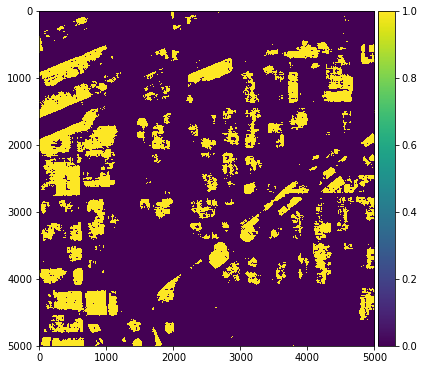

In [19]:
show_img(predict_bin_image[2])

define filter function by size

In [20]:
def filter_by_size(img: np.ndarray, filter_range:(int, int)) -> np.ndarray:
    size_min, size_max = filter_range 
    contours, hierarchy = cv2.findContours(
        img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
    )
    output_image = np.zeros(img.shape, dtype=np.uint8)
    
    for idx, contour in enumerate(contours):
        area = cv2.contourArea(contour)
        parent_idx = hierarchy[0][idx][3]
        
        if parent_idx != -1:
            continue
            
        if area >= size_min and area < size_max:
            output_image = cv2.drawContours(output_image, [contour], -1, 255, -1)
            
    return output_image

show filtered small bin image

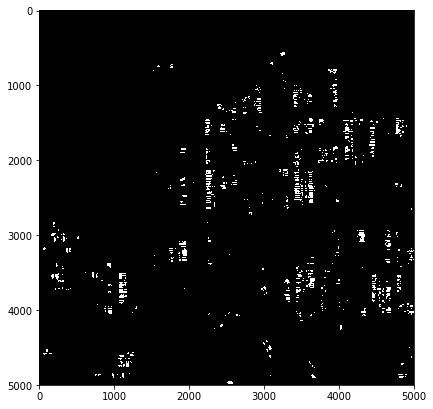

In [21]:
small_bin_image = filter_by_size(predict_bin_image[0], (0, 6800))
show_img(small_bin_image)

show filtered medium bin image

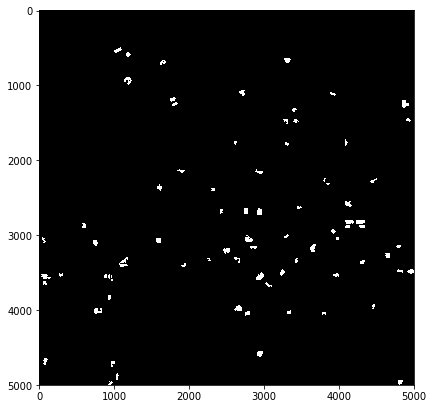

In [22]:
medium_bin_image = filter_by_size(predict_bin_image[1], (1700, 37600))
show_img(medium_bin_image)

show filtered large bin image

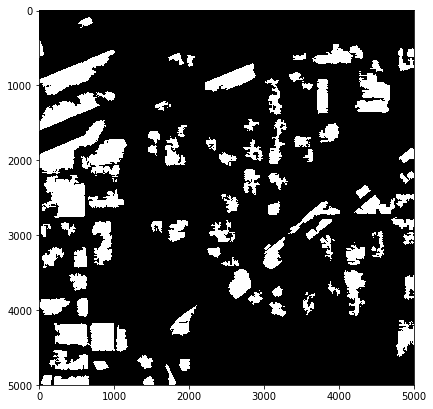

In [23]:
large_bin_image = filter_by_size(predict_bin_image[2], (9400, 5000 * 5000))
show_img(large_bin_image)

show merged output

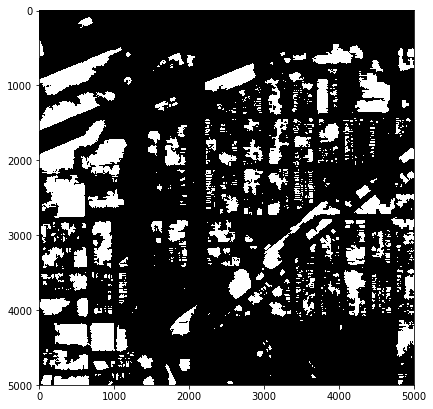

In [24]:
predict_bin_image = np.any(np.dstack([small_bin_image == 255, medium_bin_image == 255, large_bin_image == 255]), axis=-1)
show_img(predict_bin_image)

show gt output

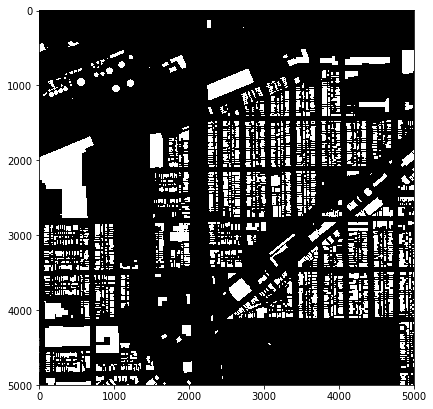

In [25]:
gt_image_path = test_image_path.parent.parent.joinpath('gt', test_image_path.name)
gt_image = imread(gt_image_path.as_posix())
gt_bin_image = gt_image > 128
show_img(gt_bin_image)

calculate intersection over union

In [26]:
medium_bin_image.shape

(5000, 5000)

In [27]:
overlap = predict_bin_image * gt_bin_image
union = predict_bin_image + gt_bin_image
iou = overlap.sum() / float(union.sum())
iou

0.23005573630197682